In [627]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
from datetime import datetime
from datetime import timedelta
import glob
import os
import numpy
import matplotlib.pyplot as plt
import re
import seaborn as sns
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':75})
plt.rcParams["figure.autolayout"] = True

%matplotlib inline

# Data Upload

#### Formatting companies file

In [ ]:
company = pd.read_csv('Superbowl_Companies.csv')
company.head(5)

,Product Type,Company,2015,2016,2017,2018,2019,2020,2021,2022
0,Beer,Budweiser,Yes,no,yes,yes,yes,no,no,yes
1,Beer,Bud Light,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes
2,candy,Mar Inc.,Yes,Yes,Yes,Yes,Yes,No,Yes,No
3,car,Jeep,Yes,Yes,No,Yes,No,Yes,Yes,No
4,car,Toyato,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes


In [ ]:
company = company.replace(to_replace=['Yes', 'yes'], value=1)
company = company.replace(to_replace=['No', 'no'], value=0)
company = company.replace(to_replace=['No ', 'no'], value=0)
company_dict = company.drop(['Product Type'], axis = 1).set_index(['Company']).T.to_dict('list')

In [ ]:
import numpy as np
list2 = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
dict_keys = []
new_dict = []

for i, j in company_dict.items():
    j = np.multiply(j, list2).tolist()
    dict_keys.append(j)
    
    for m in dict_keys:
        c = m.count(0)
    
        for n in range(c):
            m.remove(0)
        
    for list in dict_keys:
            j = list
    
    company_dict[i] = j


print(company_dict)

{'Budweiser': [2015, 2017, 2018, 2019, 2022], 'Bud Light': [2015, 2016, 2017, 2018, 2019, 2021, 2022], 'Mar Inc.': [2015, 2016, 2017, 2018, 2019, 2021], 'Jeep': [2015, 2016, 2018, 2020, 2021], 'Toyato': [2015, 2016, 2018, 2019, 2020, 2021, 2022], 'Doritos': [2015, 2016, 2018, 2019, 2020, 2022], 'Avocado from Mexico ': [2015, 2016, 2017, 2018, 2019, 2020, 2022], 'pringles': [2018, 2019], 'Pepsi/ Mountain Dew': [2015, 2016, 2018, 2019, 2020, 2022], 'Coca-Cola': [2015, 2016, 2017, 2018, 2019, 2020], 'T-Mobile': [2015, 2016, 2017, 2018, 2019, 2021, 2022], 'sprint': [2015, 2017, 2018], 'Tide': [2017, 2018, 2020, 2021], 'weather tech': [2015, 2016, 2018, 2021, 2022], 'turbotax': [2015, 2017, 2018, 2022], 'wix.com': [2015, 2017, 2018], 'squarespace': [2015, 2017, 2018, 2021, 2022], 'amazon alexa': [2018, 2019], 'uber east': [2021, 2022]}


### Dowloading from Twitter

In [720]:
superbowl_dates = ['2015-02-01', '2016-02-07', '2017-02-05', '2018-02-04', '2019-02-03', '2020-02-02', '2021-02-07', '2022-02-13']
dates_list = [datetime.strptime(date, "%Y-%m-%d").date() for date in superbowl_dates]#turning dates to datetime format
before_date = [str(date-timedelta(days=2)) for date in dates_list] #calculating dates that is 2 days before superbowl
after_date = [str(date+timedelta(days=2)) for date in dates_list]  #calculating dates that is 2 days after superbowl

In [721]:
dates_list

[datetime.date(2015, 2, 1),
 datetime.date(2016, 2, 7),
 datetime.date(2017, 2, 5),
 datetime.date(2018, 2, 4),
 datetime.date(2019, 2, 3),
 datetime.date(2020, 2, 2),
 datetime.date(2021, 2, 7),
 datetime.date(2022, 2, 13)]

In [722]:
before_date

['2015-01-30',
 '2016-02-05',
 '2017-02-03',
 '2018-02-02',
 '2019-02-01',
 '2020-01-31',
 '2021-02-05',
 '2022-02-11']

In [723]:
after_date

['2015-02-03',
 '2016-02-09',
 '2017-02-07',
 '2018-02-06',
 '2019-02-05',
 '2020-02-04',
 '2021-02-09',
 '2022-02-15']

In [724]:
def get_brand_tweets_in_year_before(brand, year):
    """
    Function to download data for days before superbowl for each brand during different years
    Data is downloaded in before folder
    """
    
    
    tweet: sntwitter.Tweet
    # Creating list to append tweet data to
    tweets_list2 = []

    # Using TwitterSearchScraper to scrape data and append tweets to list

    #calculating date from
    year_match_since = [s for s in before_date if str(year) in s]
    since = (','.join(year_match_since))
    
    #calculating date to
    year_match_after = [s for s in superbowl_dates if str(year) in s]
    until = (','.join(year_match_after))
    

    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{brand} since:{since} until:{until} lang:en filter:has_engagement').get_items()):
        #filtering for secific time range, tweets are in english and tweets have engagements

        if tweet.retweetCount > 0:
            tweets_list2.append([tweet.url, tweet.date, tweet.id, tweet.content.replace('\n', ' '), tweet.retweetCount, tweet.replyCount,
                            tweet.likeCount, tweet.user.username, tweet.user.displayname, tweet.user.followersCount, 
                            tweet.user.friendsCount, tweet.renderedContent])
        if len(tweets_list2) == 750: #pulling 750 tweets max for each brand for each year
            break
        
    # Creating a dataframe from the tweets list above
    tweets_df2 = pd.DataFrame(tweets_list2, columns=['url','Datetime', 'Tweet Id', 'Text', 'Retweet Count', 'Reply Count', 
                                                        'Like Count', 'Username', 'Display Name','Followers Count', 'Friends Count', 
                                                        'Rendered Content'])

    tweets_df2['Datetime'] = pd.to_datetime(tweets_df2['Datetime'])
    tweets_df2['Day'] = tweets_df2['Datetime'].dt.day
    tweets_df2['Month'] = tweets_df2['Datetime'].dt.month
    tweets_df2['Year'] = tweets_df2['Datetime'].dt.year
    

    # Write df to a csv file
    tweets_df2.to_csv(f'data/before/{year}_{brand}.csv', index=False, header=True)


In [725]:
def get_brand_tweets_in_year_after(brand, year):
    """
    Function to download data for days after superbowl for each brand during different years
    Data is downloaded in after folder
    """
    
    
    tweet: sntwitter.Tweet
    # Creating list to append tweet data to
    tweets_list2 = []



    year_match_since = [s for s in superbowl_dates if str(year) in s]
    since = (','.join(year_match_since))
    
    year_match_after = [s for s in after_date if str(year) in s]
    until = (','.join(year_match_after))
    


    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{brand} since:{since} until:{until} lang:en filter:has_engagement').get_items()):
        # if i>100:
        #     break
        if tweet.retweetCount > 0:
            tweets_list2.append([tweet.url, tweet.date, tweet.id, tweet.content.replace('\n', ' '), tweet.retweetCount, tweet.replyCount,
                            tweet.likeCount, tweet.user.username, tweet.user.displayname, tweet.user.followersCount, 
                            tweet.user.friendsCount, tweet.renderedContent])

        if len(tweets_list2) == 750:
            break
        
    # Creating a dataframe from the tweets list above
    tweets_df2 = pd.DataFrame(tweets_list2, columns=['url','Datetime', 'Tweet Id', 'Text', 'Retweet Count', 'Reply Count', 
                                                        'Like Count', 'Username', 'Display Name','Followers Count', 'Friends Count', 
                                                        'Rendered Content'])

    tweets_df2['Datetime'] = pd.to_datetime(tweets_df2['Datetime'])
    tweets_df2['Day'] = tweets_df2['Datetime'].dt.day
    tweets_df2['Month'] = tweets_df2['Datetime'].dt.month
    tweets_df2['Year'] = tweets_df2['Datetime'].dt.year
    

    # Write df to a csv file
    tweets_df2.to_csv(f'data/after/{year}_{brand}.csv', index=False, header=True)


In [726]:
def get_brand_tweets_in_year_after_sb(brand, year):
    """
    Function to download data for days after superbowl for each brand during different years and tweets that also contains "Superbowl" in them
    Data is downloaded in after/superbowl folder
    """
    
    
    tweet: sntwitter.Tweet
    # Creating list to append tweet data to
    tweets_list2 = []

    # Using TwitterSearchScraper to scrape data and append tweets to list

    year_match_since = [s for s in superbowl_dates if str(year) in s]
    since = (','.join(year_match_since))
    
    year_match_after = [s for s in after_date if str(year) in s]
    until = (','.join(year_match_after))
    
    #since = f'{year}-01-01'
    #until = f'{year}-03-31'
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'({brand} AND Superbowl) since:{since} until:{until} lang:en filter:has_engagement').get_items()):
        # if i>100:
        #     break
        if tweet.retweetCount > 0:
            tweets_list2.append([tweet.url, tweet.date, tweet.id, tweet.content.replace('\n', ' '), tweet.retweetCount, tweet.replyCount,
                            tweet.likeCount, tweet.user.username, tweet.user.displayname, tweet.user.followersCount, 
                            tweet.user.friendsCount, tweet.renderedContent])
        if len(tweets_list2) == 750:
            break
        
    # Creating a dataframe from the tweets list above
    tweets_df2 = pd.DataFrame(tweets_list2, columns=['url','Datetime', 'Tweet Id', 'Text', 'Retweet Count', 'Reply Count', 
                                                        'Like Count', 'Username', 'Display Name','Followers Count', 'Friends Count', 
                                                        'Rendered Content'])

    tweets_df2['Datetime'] = pd.to_datetime(tweets_df2['Datetime'])
    tweets_df2['Day'] = tweets_df2['Datetime'].dt.day
    tweets_df2['Month'] = tweets_df2['Datetime'].dt.month
    tweets_df2['Year'] = tweets_df2['Datetime'].dt.year
    

    # Write df to a csv file
    tweets_df2.to_csv(f'data/after/superbowl/{year}_{brand}.csv', index=False, header=True)


In [431]:
#dictionary for each brand and the years when theu had abn ad
brands = {
  'Budweiser': [2015, 2017, 2018, 2019, 2022], 
  'Budlight': [2015, 2016, 2017, 2018, 2019, 2021, 2022], 
  'Mar': [2015, 2016, 2017, 2018, 2019, 2021], 
  'Jeep': [2015, 2016, 2018, 2020, 2021], 
  'Toyota': [2015, 2016, 2018, 2019, 2020, 2021, 2022], 
  'Doritos': [2015, 2016, 2018, 2019, 2020, 2022], 
  'Avocado from Mexico': [2015, 2016, 2017, 2018, 2019, 2020, 2022], 
  'pringles': [2018, 2019], 
  'Pepsi': [2015, 2016, 2018, 2019, 2020, 2022], 
  'Coca-Cola': [2015, 2016, 2017, 2018, 2019, 2020], 
  'T-Mobile': [2015, 2016, 2017, 2018, 2019, 2021, 2022], 
  'sprint': [2015, 2017, 2018], 
  'Tide': [2017, 2018, 2020, 2021], 
  'weather tech': [2015, 2016, 2018, 2021, 2022], 
  'turbotax': [2015, 2017, 2018, 2022], 
  'wix.com': [2015, 2017, 2018], 
  'squarespace': [2015, 2017, 2018, 2021, 2022], 
  'amazon alexa': [2018, 2019], 
  'uber eat': [2021, 2022]
  }


In [727]:
#brands= {'Toyota': [2015, 2016, 2018, 2019, 2020, 2021, 2022]}

In [728]:
#get data for before superbowl. Date for 2 days before.
for brand, years in brands.items():
    for year in years:
        get_brand_tweets_in_year_before(brand, year) 

In [729]:
#get data for after superbowl. Date for 2 days after.
for brand, years in brands.items():
    for year in years:
        get_brand_tweets_in_year_after(brand, year)


In [730]:
#get data for after superbowl and contains "superbowl". Date for 2 days after.
for brand, years in brands.items():
    for year in years:
        get_brand_tweets_in_year_after_sb(brand, year) 

#### Data Exploration

In [735]:
companies = ["T-Mobile",
                "sprint",
                "Tide",
                "weather tech",
                "turbotax",
                "wix.com",
                "squarespace",
                "amazon alexa",
                "uber eat",#
                'Budweiser',
                'Budlight',
                'Mar',
                'Jeep',
                'Toyota', 
                'Doritos',
                'Avocado from Mexico',
                'pringles',
                'Pepsi', 
                'Coca-Cola']

In [736]:
print(glob.glob('data/before/*sprint.csv'))#print all sprint files with before folder
print(glob.glob('data/after/*sprint.csv'))#print all sprint files with after folder
print(glob.glob('data/after/superbowl/*sprint.csv'))#print all sprint files with after/superbowl folder

['data/before/2015_sprint.csv', 'data/before/2018_sprint.csv', 'data/before/2017_sprint.csv']
['data/after/2015_sprint.csv', 'data/after/2018_sprint.csv', 'data/after/2017_sprint.csv']
['data/after/superbowl/2015_sprint.csv', 'data/after/superbowl/2018_sprint.csv', 'data/after/superbowl/2017_sprint.csv']


In [737]:
print(sorted(glob.glob(f'data/before/*{company}.csv')for company in companies))

[['data/before/2015_Jeep.csv', 'data/before/2020_Jeep.csv', 'data/before/2021_Jeep.csv', 'data/before/2018_Jeep.csv', 'data/before/2016_Jeep.csv'], ['data/before/2015_sprint.csv', 'data/before/2018_sprint.csv', 'data/before/2017_sprint.csv'], ['data/before/2015_wix.com.csv', 'data/before/2018_wix.com.csv', 'data/before/2017_wix.com.csv'], ['data/before/2016_Pepsi.csv', 'data/before/2022_Pepsi.csv', 'data/before/2019_Pepsi.csv', 'data/before/2020_Pepsi.csv', 'data/before/2015_Pepsi.csv', 'data/before/2018_Pepsi.csv'], ['data/before/2016_T-Mobile.csv', 'data/before/2017_T-Mobile.csv', 'data/before/2021_T-Mobile.csv', 'data/before/2015_T-Mobile.csv', 'data/before/2022_T-Mobile.csv', 'data/before/2019_T-Mobile.csv', 'data/before/2018_T-Mobile.csv'], ['data/before/2016_weather tech.csv', 'data/before/2022_weather tech.csv', 'data/before/2018_weather tech.csv', 'data/before/2021_weather tech.csv', 'data/before/2015_weather tech.csv'], ['data/before/2017_Avocado from Mexico.csv', 'data/before

In [738]:
def print_shape(filenames):
    for company in filenames:
        for filename in company: 
            print(filename)
            data = pd.read_csv(filename, lineterminator='\n')
            print(data.shape)

less_than_rows = 100
def print_low_rows(filenames):
    for company in filenames:
        for filename in company:
            data = pd.read_csv(filename, lineterminator='\n')           
            if data.shape[0]<less_than_rows:
                print(f'files with low number of rows {filename}')

In [739]:
#before folder
filenames_before = sorted(glob.glob(f'data/before/*{company}.csv') for company in companies)
print_shape(filenames_before)

data/before/2015_Jeep.csv
(750, 15)
data/before/2020_Jeep.csv
(324, 15)
data/before/2021_Jeep.csv
(322, 15)
data/before/2018_Jeep.csv
(349, 15)
data/before/2016_Jeep.csv
(659, 15)
data/before/2015_sprint.csv
(750, 15)
data/before/2018_sprint.csv
(750, 15)
data/before/2017_sprint.csv
(750, 15)
data/before/2015_wix.com.csv
(627, 15)
data/before/2018_wix.com.csv
(45, 15)
data/before/2017_wix.com.csv
(133, 15)
data/before/2016_Pepsi.csv
(518, 15)
data/before/2022_Pepsi.csv
(454, 15)
data/before/2019_Pepsi.csv
(505, 15)
data/before/2020_Pepsi.csv
(750, 15)
data/before/2015_Pepsi.csv
(750, 15)
data/before/2018_Pepsi.csv
(601, 15)
data/before/2016_T-Mobile.csv
(278, 15)
data/before/2017_T-Mobile.csv
(627, 15)
data/before/2021_T-Mobile.csv
(394, 15)
data/before/2015_T-Mobile.csv
(338, 15)
data/before/2022_T-Mobile.csv
(250, 15)
data/before/2019_T-Mobile.csv
(209, 15)
data/before/2018_T-Mobile.csv
(242, 15)
data/before/2016_weather tech.csv
(30, 15)
data/before/2022_weather tech.csv
(19, 15)
da

In [740]:
less_than_rows = 100
print_low_rows(filenames_before)
#wix, weather tech, square space, turbotax, uber eat, Avocado from Mexico have low data

files with low number of rows data/before/2018_wix.com.csv
files with low number of rows data/before/2016_weather tech.csv
files with low number of rows data/before/2022_weather tech.csv
files with low number of rows data/before/2018_weather tech.csv
files with low number of rows data/before/2021_weather tech.csv
files with low number of rows data/before/2015_weather tech.csv
files with low number of rows data/before/2017_Avocado from Mexico.csv
files with low number of rows data/before/2018_Avocado from Mexico.csv
files with low number of rows data/before/2022_Avocado from Mexico.csv
files with low number of rows data/before/2019_Avocado from Mexico.csv
files with low number of rows data/before/2016_Avocado from Mexico.csv
files with low number of rows data/before/2015_Avocado from Mexico.csv
files with low number of rows data/before/2020_Avocado from Mexico.csv
files with low number of rows data/before/2022_Budweiser.csv
files with low number of rows data/before/2017_squarespace.csv


In [741]:
#after folder file sizes
filenames_after = sorted(glob.glob(f'data/after/*{company}.csv') for company in companies)
print_shape(filenames_after)
#similar trend

data/after/2015_Jeep.csv
(750, 15)
data/after/2020_Jeep.csv
(750, 15)
data/after/2021_Jeep.csv
(750, 15)
data/after/2018_Jeep.csv
(750, 15)
data/after/2016_Jeep.csv
(750, 15)
data/after/2015_sprint.csv
(750, 15)
data/after/2018_sprint.csv
(750, 15)
data/after/2017_sprint.csv
(750, 15)
data/after/2015_wix.com.csv
(655, 15)
data/after/2018_wix.com.csv
(42, 15)
data/after/2017_wix.com.csv
(143, 15)
data/after/2016_Pepsi.csv
(750, 15)
data/after/2022_Pepsi.csv
(750, 15)
data/after/2019_Pepsi.csv
(750, 15)
data/after/2020_Pepsi.csv
(750, 15)
data/after/2015_Pepsi.csv
(750, 15)
data/after/2018_Pepsi.csv
(750, 15)
data/after/2016_T-Mobile.csv
(750, 15)
data/after/2017_T-Mobile.csv
(750, 15)
data/after/2021_T-Mobile.csv
(635, 15)
data/after/2015_T-Mobile.csv
(750, 15)
data/after/2022_T-Mobile.csv
(456, 15)
data/after/2019_T-Mobile.csv
(750, 15)
data/after/2018_T-Mobile.csv
(750, 15)
data/after/2016_weather tech.csv
(136, 15)
data/after/2022_weather tech.csv
(43, 15)
data/after/2018_weather tec

In [742]:
less_than_rows = 100
print_low_rows(filenames_after)
#uber eat, wix, weather tech, avocado from mexico, have low numbers
#there are less number of files that has less than 100 tweets after superbowl 

files with low number of rows data/after/2018_wix.com.csv
files with low number of rows data/after/2022_weather tech.csv
files with low number of rows data/after/2021_weather tech.csv
files with low number of rows data/after/2018_Avocado from Mexico.csv
files with low number of rows data/after/2016_Avocado from Mexico.csv
files with low number of rows data/after/2020_Avocado from Mexico.csv
files with low number of rows data/after/2022_uber eat.csv
files with low number of rows data/after/2021_uber eat.csv


In [743]:
#after/superbowl folder file sizes
filenames_after_superbowl = sorted(glob.glob(f'data/after/superbowl/*{company}.csv') for company in companies)
print_shape(filenames_after_superbowl)

data/after/superbowl/2015_Jeep.csv
(173, 15)
data/after/superbowl/2020_Jeep.csv
(219, 15)
data/after/superbowl/2021_Jeep.csv
(316, 15)
data/after/superbowl/2018_Jeep.csv
(136, 15)
data/after/superbowl/2016_Jeep.csv
(87, 15)
data/after/superbowl/2015_sprint.csv
(61, 15)
data/after/superbowl/2018_sprint.csv
(74, 15)
data/after/superbowl/2017_sprint.csv
(76, 15)
data/after/superbowl/2015_wix.com.csv
(12, 15)
data/after/superbowl/2018_wix.com.csv
(1, 15)
data/after/superbowl/2017_wix.com.csv
(4, 15)
data/after/superbowl/2016_Pepsi.csv
(148, 15)
data/after/superbowl/2022_Pepsi.csv
(228, 15)
data/after/superbowl/2019_Pepsi.csv
(340, 15)
data/after/superbowl/2020_Pepsi.csv
(195, 15)
data/after/superbowl/2015_Pepsi.csv
(232, 15)
data/after/superbowl/2018_Pepsi.csv
(254, 15)
data/after/superbowl/2016_T-Mobile.csv
(39, 15)
data/after/superbowl/2017_T-Mobile.csv
(112, 15)
data/after/superbowl/2021_T-Mobile.csv
(26, 15)
data/after/superbowl/2015_T-Mobile.csv
(53, 15)
data/after/superbowl/2022_T-Mo

In [744]:
less_than_rows = 10
print_low_rows(filenames_after_superbowl)
#wix, weather tech, uber eat have less numer of rows

files with low number of rows data/after/superbowl/2018_wix.com.csv
files with low number of rows data/after/superbowl/2017_wix.com.csv
files with low number of rows data/after/superbowl/2016_weather tech.csv
files with low number of rows data/after/superbowl/2022_weather tech.csv
files with low number of rows data/after/superbowl/2018_weather tech.csv
files with low number of rows data/after/superbowl/2021_weather tech.csv
files with low number of rows data/after/superbowl/2015_weather tech.csv
files with low number of rows data/after/superbowl/2016_Avocado from Mexico.csv
files with low number of rows data/after/superbowl/2015_Mar.csv
files with low number of rows data/after/superbowl/2016_Mar.csv
files with low number of rows data/after/superbowl/2022_uber eat.csv
files with low number of rows data/after/superbowl/2021_uber eat.csv


#### Joining Files

In [745]:
def prep_concat(filenames):
    for files in filenames:
        for file in files:
            df = pd.read_csv(file, lineterminator='\n')
            directory = file.partition("/")[2].partition("/")[0]
            company_name = file.partition("_")[2].partition(".")[0]
            df['Company_Name'] = company_name
            df['Directory'] = directory
            df = df.reset_index(drop=True)
            yield df

In [746]:
before_df = pd.concat((prep_concat(filenames_before))).reset_index(drop=True)
before_df.head()

,url,Datetime,Tweet Id,Text,Retweet Count,Reply Count,Like Count,Username,Display Name,Followers Count,Friends Count,Rendered Content,Day,Month,Year,Company_Name,Directory
0,https://twitter.com/UWnt2/status/5616740628090...,2015-01-31 23:55:06+00:00,561674062809022465,Amazing weekend #off-road &amp; #camping at Th...,1,0,1,UWnt2,YOUNTO.com,433,711,Amazing weekend #off-road &amp; #camping at Th...,31,1,2015,Jeep,before
1,https://twitter.com/ShowDreamCar/status/561671...,2015-01-31 23:46:28+00:00,561671888288493568,List of things better than perfect Jeep weathe...,1,0,2,ShowDreamCar,Car Pictures,12775,19,List of things better than perfect Jeep weathe...,31,1,2015,Jeep,before
2,https://twitter.com/ShowDreamCar/status/561671...,2015-01-31 23:43:45+00:00,561671203966840834,#tbtuesday 1 yr ago when I first started worki...,1,0,1,ShowDreamCar,Car Pictures,12775,19,#tbtuesday 1 yr ago when I first started worki...,31,1,2015,Jeep,before
3,https://twitter.com/_VictoriaManson/status/561...,2015-01-31 23:28:26+00:00,561667350819520512,"Okay, that jeep is beautiful! Loving everythin...",2,0,0,_VictoriaManson,Vicki,4432,4950,"Okay, that jeep is beautiful! Loving everythin...",31,1,2015,Jeep,before
4,https://twitter.com/Jeepings/status/5616670153...,2015-01-31 23:27:06+00:00,561667015312961536,They call my house The Jeep Garage ;) #jeeplif...,3,0,11,Jeepings,Northern Jeeper™,1619,738,They call my house The Jeep Garage ;) #jeeplif...,31,1,2015,Jeep,before


In [747]:
before_df.shape

(32291, 17)

In [748]:
after_df = pd.concat((prep_concat(filenames_after))).reset_index(drop=True)
after_df.head()

,url,Datetime,Tweet Id,Text,Retweet Count,Reply Count,Like Count,Username,Display Name,Followers Count,Friends Count,Rendered Content,Day,Month,Year,Company_Name,Directory
0,https://twitter.com/billyg67/status/5623991633...,2015-02-02 23:56:24+00:00,562399163350925312,@SolarTJChick I would love for all jeepgirls t...,4,3,9,billyg67,Porsche & schmoopy,4435,4885,@SolarTJChick I would love for all jeepgirls t...,2,2,2015,Jeep,after
1,https://twitter.com/thefox1019/status/56239886...,2015-02-02 23:55:12+00:00,562398865127530498,We're paying a visit to Bundoora RIGHT NOW! Ge...,1,0,2,thefox1019,The Fox 101.9,42613,296,We're paying a visit to Bundoora RIGHT NOW! Ge...,2,2,2015,Jeep,after
2,https://twitter.com/ChadHaase/status/562397634...,2015-02-02 23:50:19+00:00,562397634976301056,Jeep stuck in mud in France 1944. http://t.co/...,11,1,14,ChadHaase,Chad Haase,1086,673,Jeep stuck in mud in France 1944. http://t.co/...,2,2,2015,Jeep,after
3,https://twitter.com/CiscaPr/status/56239722094...,2015-02-02 23:48:40+00:00,562397220943589378,Good morning sexy people! Have a sexy Tuesday!...,2,1,7,CiscaPr,Francisca Prandayani,6077,1992,Good morning sexy people! Have a sexy Tuesday!...,2,2,2015,Jeep,after
4,https://twitter.com/FlexinJC/status/5623969134...,2015-02-02 23:47:27+00:00,562396913417617408,@YellowJeepJewel Wow. You don't need people li...,1,1,2,FlexinJC,James Miller,1156,2090,@YellowJeepJewel Wow. You don't need people li...,2,2,2015,Jeep,after


In [749]:
after_df.shape

(51009, 17)

In [750]:
after_superbowl_df = pd.concat((prep_concat(filenames_after_superbowl))).reset_index(drop=True)
after_superbowl_df.head()

,url,Datetime,Tweet Id,Text,Retweet Count,Reply Count,Like Count,Username,Display Name,Followers Count,Friends Count,Rendered Content,Day,Month,Year,Company_Name,Directory
0,https://twitter.com/NihadAwad/status/562388095...,2015-02-02 23:12:25+00:00,562388095522193410,We should all commend @Jeep for being inclusiv...,2,0,5,NihadAwad,Nihad Awad,35774,1849,We should all commend @Jeep for being inclusiv...,2,2,2015,Jeep,after
1,https://twitter.com/i4unews/status/56238505431...,2015-02-02 23:00:20+00:00,562385054312464384,Jeep #SuperBowl 2015 Ad - I4U News http://t.co...,2,0,0,i4unews,I4U News,12101,4650,Jeep #SuperBowl 2015 Ad - I4U News buff.ly/1HI...,2,2,2015,Jeep,after
2,https://twitter.com/LoveInshAllah/status/56237...,2015-02-02 22:26:35+00:00,562376561643372544,Make sure to thank @Jeep! “Racists whine abt i...,1,0,2,LoveInshAllah,"Love, InshAllah",6774,1842,Make sure to thank @Jeep! “Racists whine abt i...,2,2,2015,Jeep,after
3,https://twitter.com/MirDAliZ/status/5623749644...,2015-02-02 22:20:14+00:00,562374964473372672,Peace is the message that was being conveyed b...,2,0,1,MirDAliZ,MIR DAWOOD ALI,15,89,Peace is the message that was being conveyed b...,2,2,2015,Jeep,after
4,https://twitter.com/MaryWbn/status/56236490636...,2015-02-02 21:40:16+00:00,562364906365005826,Embarrassing “@Adweek: Jeep's #SuperBowl ad is...,1,0,0,MaryWbn,Mary Weatherburn,1378,1779,Embarrassing “@Adweek: Jeep's #SuperBowl ad is...,2,2,2015,Jeep,after


In [751]:
after_superbowl_df.shape

(11357, 17)

### Exploring Concated Files

### Before files

In [752]:
before_df.head()

,url,Datetime,Tweet Id,Text,Retweet Count,Reply Count,Like Count,Username,Display Name,Followers Count,Friends Count,Rendered Content,Day,Month,Year,Company_Name,Directory
0,https://twitter.com/UWnt2/status/5616740628090...,2015-01-31 23:55:06+00:00,561674062809022465,Amazing weekend #off-road &amp; #camping at Th...,1,0,1,UWnt2,YOUNTO.com,433,711,Amazing weekend #off-road &amp; #camping at Th...,31,1,2015,Jeep,before
1,https://twitter.com/ShowDreamCar/status/561671...,2015-01-31 23:46:28+00:00,561671888288493568,List of things better than perfect Jeep weathe...,1,0,2,ShowDreamCar,Car Pictures,12775,19,List of things better than perfect Jeep weathe...,31,1,2015,Jeep,before
2,https://twitter.com/ShowDreamCar/status/561671...,2015-01-31 23:43:45+00:00,561671203966840834,#tbtuesday 1 yr ago when I first started worki...,1,0,1,ShowDreamCar,Car Pictures,12775,19,#tbtuesday 1 yr ago when I first started worki...,31,1,2015,Jeep,before
3,https://twitter.com/_VictoriaManson/status/561...,2015-01-31 23:28:26+00:00,561667350819520512,"Okay, that jeep is beautiful! Loving everythin...",2,0,0,_VictoriaManson,Vicki,4432,4950,"Okay, that jeep is beautiful! Loving everythin...",31,1,2015,Jeep,before
4,https://twitter.com/Jeepings/status/5616670153...,2015-01-31 23:27:06+00:00,561667015312961536,They call my house The Jeep Garage ;) #jeeplif...,3,0,11,Jeepings,Northern Jeeper™,1619,738,They call my house The Jeep Garage ;) #jeeplif...,31,1,2015,Jeep,before


In [753]:
before_df.shape

(32291, 17)

In [755]:
before_df.dtypes

url                 object
Datetime            object
Tweet Id             int64
Text                object
Retweet Count        int64
Reply Count          int64
Like Count           int64
Username            object
Display Name        object
Followers Count      int64
Friends Count        int64
Rendered Content    object
Day                  int64
Month                int64
Year                 int64
Company_Name        object
Directory           object
dtype: object

In [756]:
before_df.columns

Index(['url', 'Datetime', 'Tweet Id', 'Text', 'Retweet Count', 'Reply Count',
       'Like Count', 'Username', 'Display Name', 'Followers Count',
       'Friends Count', 'Rendered Content', 'Day', 'Month', 'Year',
       'Company_Name', 'Directory'],
      dtype='object')

In [757]:
before_df.describe()

,Tweet Id,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count,Day,Month,Year
count,3.229100e+04,32291.000000,32291.000000,32291.000000,3.229100e+04,32291.000000,32291.000000,32291.000000,32291.000000
mean,9.335751e+17,10.887182,2.407110,42.971107,1.994537e+05,4394.974172,11.007680,1.739959,2017.802515
std,2.936295e+17,138.828493,44.088297,918.136194,1.726626e+06,18731.853616,11.853028,0.438664,2.213305
min,5.609507e+17,1.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,2015.000000
25%,6.956477e+17,1.000000,0.000000,1.000000,6.680000e+02,310.000000,3.000000,1.000000,2016.000000
50%,9.594206e+17,1.000000,0.000000,3.000000,2.849000e+03,821.000000,5.000000,2.000000,2018.000000
75%,1.223069e+18,3.000000,1.000000,10.000000,1.844800e+04,2363.000000,30.000000,2.000000,2020.000000
max,1.492649e+18,12668.000000,7047.000000,93169.000000,7.756463e+07,902426.000000,31.000000,2.000000,2022.000000


In [758]:
before_df.groupby('Company_Name').mean().filter(regex='Count$',axis=1)

,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count
Company_Name,,,,,
Avocado from Mexico,7.245000,2.620000,6.650000,175989.195000,17258.600000
Budlight,13.476765,3.681955,65.061557,361102.984309,2996.409777
Budweiser,9.104816,2.132011,24.156941,316883.579037,4885.215297
Coca-Cola,12.992099,1.700903,31.886757,287951.140331,7035.234763
Doritos,14.318605,2.049612,98.542636,220235.940310,3370.938760
Jeep,6.201747,1.341930,24.570300,46794.937188,2486.914725
Mar,11.432222,2.288222,30.609111,56827.264000,5280.373333
Pepsi,15.380939,5.153717,59.462549,303302.615428,4258.319173
T-Mobile,17.715569,3.726689,86.783576,402266.858426,4999.523524


In [759]:
before_df.groupby('Company_Name').sum().filter(regex='Count$',axis=1)

,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count
Company_Name,,,,,
Avocado from Mexico,1449,524,1330,35197839,3451720
Budlight,22331,6101,107807,598347645,4965051
Budweiser,16070,3763,42637,559299517,8622405
Coca-Cola,34533,4521,84755,765374131,18699654
Doritos,18471,2644,127120,284104363,4348511
Jeep,14909,3226,59067,112495029,5978543
Mar,51445,10297,137741,255722688,23761680
Pepsi,55033,18440,212757,1085216758,15236266
T-Mobile,41419,8713,202900,940499915,11688886


In [760]:
before_df.groupby(['Company_Name', 'Year']).sum().filter(regex='Count$',axis=1).sort_values(by = "Retweet Count",ascending = False).reset_index()
#T-mobile, coca-cola, mar, pepsi tend to have high social engagement.

,Company_Name,Year,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count
0,T-Mobile,2021,21228,4447,129149,77505391,1576775
1,Coca-Cola,2020,17337,1166,39144,82906963,1966534
2,Mar,2018,17305,2812,30413,33958308,3676648
3,Pepsi,2015,15057,2139,20632,124483867,3166859
4,Toyota,2022,14383,4450,69698,177956523,1921719
...,...,...,...,...,...,...,...
87,weather tech,2016,69,18,106,1609593,132362
88,weather tech,2022,58,23,461,645375,46910
89,weather tech,2018,48,15,111,1082882,130858
90,Avocado from Mexico,2018,24,3,57,13418,7807


In [761]:
before_df.groupby('Company_Name').median().filter(regex='Count$',axis=1)
# data is highly skeweded thats why mean and median values are so different

,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count
Company_Name,,,,,
Avocado from Mexico,1.0,0.0,1.0,27948.0,4987.0
Budlight,1.0,0.0,3.0,4024.0,589.0
Budweiser,1.0,0.0,2.0,2038.0,820.0
Coca-Cola,2.0,0.0,3.0,5179.5,979.5
Doritos,1.0,0.0,3.0,1537.5,699.5
Jeep,1.0,0.0,3.0,1594.5,609.5
Mar,2.0,0.0,3.0,2930.0,988.0
Pepsi,2.0,0.0,4.0,2531.0,782.5
T-Mobile,1.0,0.0,3.0,2665.5,774.0


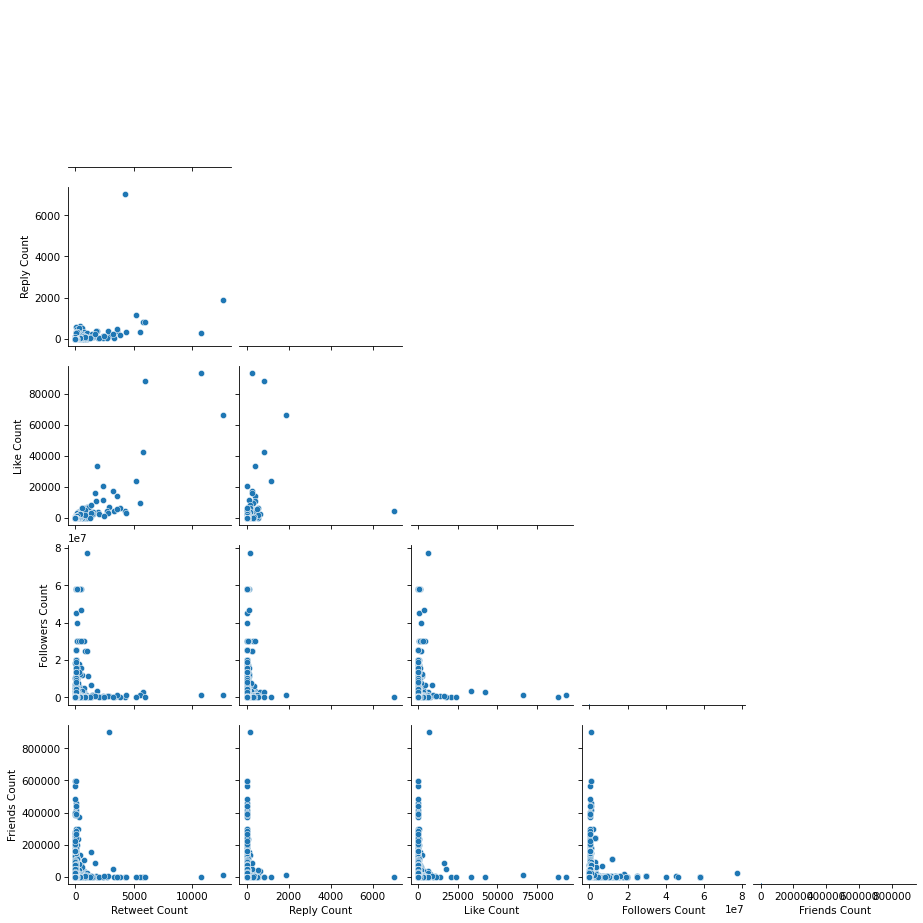

In [762]:
sns.pairplot(before_df.filter(regex='Count$', axis = 1).reset_index(drop=True), corner=True)
#There might be some correlation between like, reply and retweet metric

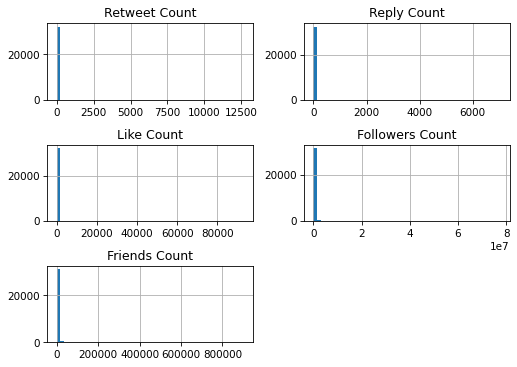

In [763]:
before_df.filter(regex='Count$', axis = 1).reset_index(drop=True).hist(bins = 50)
plt.show()

### After Files

In [764]:
after_df.head()

,url,Datetime,Tweet Id,Text,Retweet Count,Reply Count,Like Count,Username,Display Name,Followers Count,Friends Count,Rendered Content,Day,Month,Year,Company_Name,Directory
0,https://twitter.com/billyg67/status/5623991633...,2015-02-02 23:56:24+00:00,562399163350925312,@SolarTJChick I would love for all jeepgirls t...,4,3,9,billyg67,Porsche & schmoopy,4435,4885,@SolarTJChick I would love for all jeepgirls t...,2,2,2015,Jeep,after
1,https://twitter.com/thefox1019/status/56239886...,2015-02-02 23:55:12+00:00,562398865127530498,We're paying a visit to Bundoora RIGHT NOW! Ge...,1,0,2,thefox1019,The Fox 101.9,42613,296,We're paying a visit to Bundoora RIGHT NOW! Ge...,2,2,2015,Jeep,after
2,https://twitter.com/ChadHaase/status/562397634...,2015-02-02 23:50:19+00:00,562397634976301056,Jeep stuck in mud in France 1944. http://t.co/...,11,1,14,ChadHaase,Chad Haase,1086,673,Jeep stuck in mud in France 1944. http://t.co/...,2,2,2015,Jeep,after
3,https://twitter.com/CiscaPr/status/56239722094...,2015-02-02 23:48:40+00:00,562397220943589378,Good morning sexy people! Have a sexy Tuesday!...,2,1,7,CiscaPr,Francisca Prandayani,6077,1992,Good morning sexy people! Have a sexy Tuesday!...,2,2,2015,Jeep,after
4,https://twitter.com/FlexinJC/status/5623969134...,2015-02-02 23:47:27+00:00,562396913417617408,@YellowJeepJewel Wow. You don't need people li...,1,1,2,FlexinJC,James Miller,1156,2090,@YellowJeepJewel Wow. You don't need people li...,2,2,2015,Jeep,after


In [765]:
after_df.shape

(51009, 17)

In [766]:
after_df.describe()

,Tweet Id,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count,Day,Month,Year
count,5.100900e+04,51009.000000,51009.000000,51009.000000,5.100900e+04,5.100900e+04,51009.000000,51009.0,51009.000000
mean,9.568575e+17,13.400694,2.475387,50.963967,2.609123e+05,5.654656e+03,5.555882,2.0,2017.971574
std,2.925907e+17,390.542750,30.177216,1293.976243,1.341476e+06,1.956594e+04,3.207872,0.0,2.205243
min,5.616762e+17,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,2.0,2015.000000
25%,6.965806e+17,1.000000,0.000000,1.000000,6.480000e+02,3.830000e+02,3.000000,2.0,2016.000000
50%,9.603448e+17,1.000000,0.000000,3.000000,3.125000e+03,9.800000e+02,5.000000,2.0,2018.000000
75%,1.224009e+18,3.000000,1.000000,10.000000,2.667000e+04,2.930000e+03,8.000000,2.0,2020.000000
max,1.493374e+18,56260.000000,4830.000000,207148.000000,7.503112e+07,1.428329e+06,14.000000,2.0,2022.000000


In [767]:
after_df.columns

Index(['url', 'Datetime', 'Tweet Id', 'Text', 'Retweet Count', 'Reply Count',
       'Like Count', 'Username', 'Display Name', 'Followers Count',
       'Friends Count', 'Rendered Content', 'Day', 'Month', 'Year',
       'Company_Name', 'Directory'],
      dtype='object')

In [768]:
after_df.dtypes

url                 object
Datetime            object
Tweet Id             int64
Text                object
Retweet Count        int64
Reply Count          int64
Like Count           int64
Username            object
Display Name        object
Followers Count      int64
Friends Count        int64
Rendered Content    object
Day                  int64
Month                int64
Year                 int64
Company_Name        object
Directory           object
dtype: object

In [769]:
after_df.describe()

,Tweet Id,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count,Day,Month,Year
count,5.100900e+04,51009.000000,51009.000000,51009.000000,5.100900e+04,5.100900e+04,51009.000000,51009.0,51009.000000
mean,9.568575e+17,13.400694,2.475387,50.963967,2.609123e+05,5.654656e+03,5.555882,2.0,2017.971574
std,2.925907e+17,390.542750,30.177216,1293.976243,1.341476e+06,1.956594e+04,3.207872,0.0,2.205243
min,5.616762e+17,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,2.0,2015.000000
25%,6.965806e+17,1.000000,0.000000,1.000000,6.480000e+02,3.830000e+02,3.000000,2.0,2016.000000
50%,9.603448e+17,1.000000,0.000000,3.000000,3.125000e+03,9.800000e+02,5.000000,2.0,2018.000000
75%,1.224009e+18,3.000000,1.000000,10.000000,2.667000e+04,2.930000e+03,8.000000,2.0,2020.000000
max,1.493374e+18,56260.000000,4830.000000,207148.000000,7.503112e+07,1.428329e+06,14.000000,2.0,2022.000000


In [770]:
after_df.groupby('Company_Name').mean().filter(regex='Count$',axis=1)

,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count
Company_Name,,,,,
Avocado from Mexico,7.191904,2.259370,17.219640,2.478452e+05,5948.222639
Budlight,13.925171,3.357402,63.965914,1.964389e+05,2884.718233
Budweiser,26.420755,2.447484,100.568868,9.852033e+04,3929.434277
Coca-Cola,11.083294,1.477327,32.898091,1.149393e+06,20977.045823
Doritos,28.838797,4.508478,133.415555,1.394784e+05,3675.637124
Jeep,8.602133,2.314400,36.438933,1.136707e+05,4301.316533
Mar,6.636222,1.044444,15.490222,6.123289e+04,4075.906889
Pepsi,14.153778,2.732889,49.945111,1.914844e+05,4538.964000
T-Mobile,16.315431,3.939682,44.693452,5.238889e+05,5519.112993


In [771]:
after_df.groupby('Company_Name').sum().filter(regex='Count$',axis=1)

,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count
Company_Name,,,,,
Avocado from Mexico,9594,3014,22971,330625471,7934929
Budlight,69041,16646,317143,973943997,14302433
Budweiser,84018,7783,319809,313294658,12495601
Coca-Cola,46439,6190,137843,4815956816,87893822
Doritos,127554,19941,590097,616912817,16257343
Jeep,32258,8679,136646,426265229,16129937
Mar,29863,4700,69706,275547989,18341581
Pepsi,63692,12298,224753,861679950,20425338
T-Mobile,78983,19072,216361,2536146224,26718026


In [772]:
after_df.groupby(['Company_Name', 'Year']).sum().filter(regex='Count$',axis=1).sort_values(by = "Retweet Count",ascending = False).reset_index()
#Doritos, Budweiser, T-mobile, pepsi tend to have high social engagement.

,Company_Name,Year,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count
0,Doritos,2018,67440,2607,261161,81322050,2725017
1,Budweiser,2019,51144,2520,174237,60397339,2107096
2,T-Mobile,2021,44015,7339,71772,204411226,3062553
3,Pepsi,2016,27852,1578,21624,207102497,3965550
4,Coca-Cola,2016,26002,1307,45040,181628283,5495557
...,...,...,...,...,...,...,...
87,squarespace,2021,414,219,3133,24606683,757358
88,Avocado from Mexico,2018,237,58,799,3759682,565774
89,weather tech,2021,224,119,2399,44259564,518532
90,weather tech,2022,136,75,863,3502302,411503


In [773]:
after_df.groupby('Company_Name').median().filter(regex='Count$',axis=1)
# data is highly skeweded thats why mean and median values are so different

,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count
Company_Name,,,,,
Avocado from Mexico,1.0,0.0,2.0,3692.0,1281.0
Budlight,1.0,0.0,4.0,3076.5,769.0
Budweiser,1.0,0.0,3.0,2531.5,987.0
Coca-Cola,1.0,0.0,2.0,15701.0,2444.0
Doritos,1.0,0.0,4.0,2712.0,879.0
Jeep,1.0,0.0,4.0,2485.0,955.0
Mar,2.0,0.0,2.0,3060.5,950.0
Pepsi,1.0,0.0,3.0,1654.0,983.0
T-Mobile,1.0,0.0,3.0,4097.0,1129.0


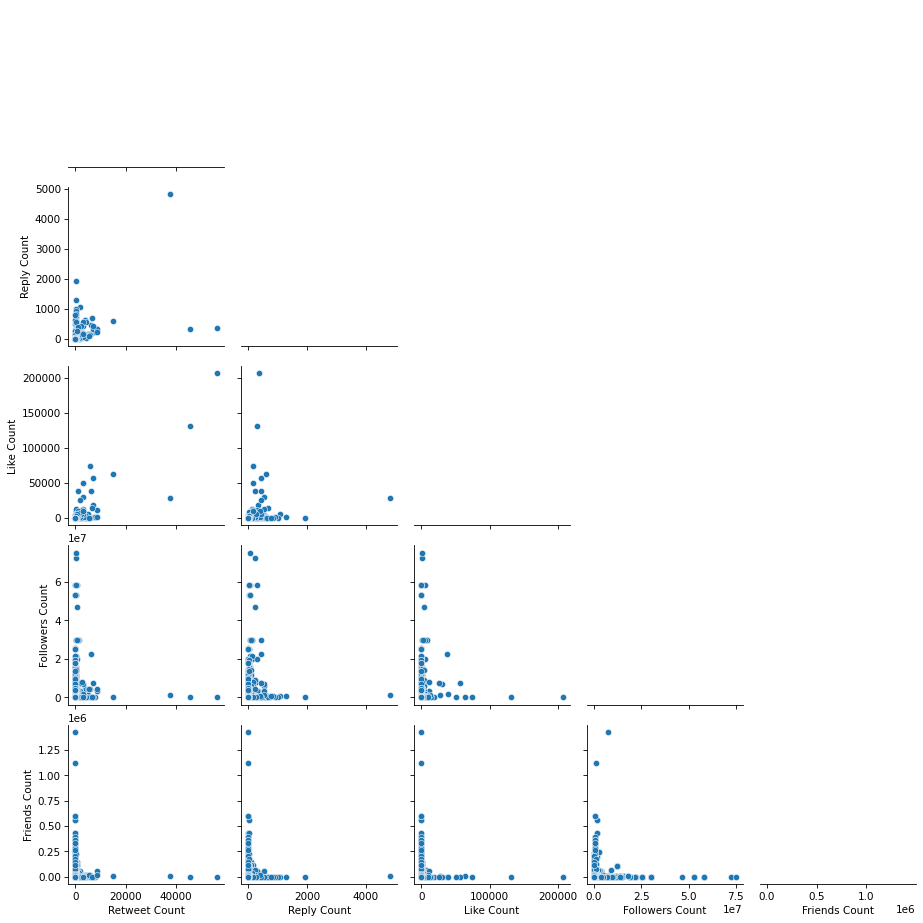

In [774]:
sns.pairplot(after_df.filter(regex='Count$', axis = 1).reset_index(drop=True), corner=True)
#There might be some correlation between like, reply and retweet metric

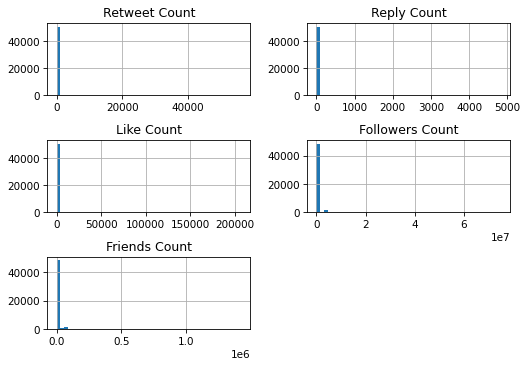

In [775]:
after_df.filter(regex='Count$', axis = 1).reset_index(drop=True).hist(bins = 50)
plt.show()
#skewed data set

### After Superbowl Data

In [776]:
after_superbowl_df.head()

,url,Datetime,Tweet Id,Text,Retweet Count,Reply Count,Like Count,Username,Display Name,Followers Count,Friends Count,Rendered Content,Day,Month,Year,Company_Name,Directory
0,https://twitter.com/NihadAwad/status/562388095...,2015-02-02 23:12:25+00:00,562388095522193410,We should all commend @Jeep for being inclusiv...,2,0,5,NihadAwad,Nihad Awad,35774,1849,We should all commend @Jeep for being inclusiv...,2,2,2015,Jeep,after
1,https://twitter.com/i4unews/status/56238505431...,2015-02-02 23:00:20+00:00,562385054312464384,Jeep #SuperBowl 2015 Ad - I4U News http://t.co...,2,0,0,i4unews,I4U News,12101,4650,Jeep #SuperBowl 2015 Ad - I4U News buff.ly/1HI...,2,2,2015,Jeep,after
2,https://twitter.com/LoveInshAllah/status/56237...,2015-02-02 22:26:35+00:00,562376561643372544,Make sure to thank @Jeep! “Racists whine abt i...,1,0,2,LoveInshAllah,"Love, InshAllah",6774,1842,Make sure to thank @Jeep! “Racists whine abt i...,2,2,2015,Jeep,after
3,https://twitter.com/MirDAliZ/status/5623749644...,2015-02-02 22:20:14+00:00,562374964473372672,Peace is the message that was being conveyed b...,2,0,1,MirDAliZ,MIR DAWOOD ALI,15,89,Peace is the message that was being conveyed b...,2,2,2015,Jeep,after
4,https://twitter.com/MaryWbn/status/56236490636...,2015-02-02 21:40:16+00:00,562364906365005826,Embarrassing “@Adweek: Jeep's #SuperBowl ad is...,1,0,0,MaryWbn,Mary Weatherburn,1378,1779,Embarrassing “@Adweek: Jeep's #SuperBowl ad is...,2,2,2015,Jeep,after


In [777]:
after_superbowl_df.shape

(11357, 17)

In [778]:
after_superbowl_df.dtypes

url                 object
Datetime            object
Tweet Id            object
Text                object
Retweet Count       object
Reply Count         object
Like Count          object
Username            object
Display Name        object
Followers Count     object
Friends Count       object
Rendered Content    object
Day                 object
Month               object
Year                object
Company_Name        object
Directory           object
dtype: object

In [779]:
after_superbowl_df[['Like Count','Followers Count', 'Friends Count','Reply Count', 'Day','Month', 'Year', 'Tweet Id', 'Retweet Count']] = after_superbowl_df[['Like Count','Followers Count', 'Friends Count','Reply Count', 'Day','Month', 'Year','Tweet Id', 'Retweet Count']].astype(int)

In [780]:
after_superbowl_df.dtypes

url                 object
Datetime            object
Tweet Id             int64
Text                object
Retweet Count        int64
Reply Count          int64
Like Count           int64
Username            object
Display Name        object
Followers Count      int64
Friends Count        int64
Rendered Content    object
Day                  int64
Month                int64
Year                 int64
Company_Name        object
Directory           object
dtype: object

In [781]:
after_superbowl_df.describe()

,Tweet Id,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count,Day,Month,Year
count,1.135700e+04,11357.000000,11357.000000,11357.000000,1.135700e+04,1.135700e+04,11357.000000,11357.0,11357.000000
mean,9.296469e+17,9.642863,3.482434,36.119398,1.270240e+05,6.557121e+03,5.145109,2.0,2017.767456
std,2.749547e+17,84.799577,185.033692,372.264399,7.455504e+05,4.002452e+04,2.946913,0.0,2.072243
min,5.616825e+17,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,2.0,2015.000000
25%,6.965021e+17,1.000000,0.000000,1.000000,6.480000e+02,4.760000e+02,3.000000,2.0,2016.000000
50%,9.603047e+17,1.000000,0.000000,4.000000,3.086000e+03,1.113000e+03,5.000000,2.0,2018.000000
75%,1.092230e+18,3.000000,1.000000,12.000000,2.057000e+04,2.931000e+03,6.000000,2.0,2019.000000
max,1.493367e+18,5674.000000,19694.000000,27067.000000,1.579631e+07,1.431616e+06,14.000000,2.0,2022.000000


In [782]:
after_superbowl_df.columns

Index(['url', 'Datetime', 'Tweet Id', 'Text', 'Retweet Count', 'Reply Count',
       'Like Count', 'Username', 'Display Name', 'Followers Count',
       'Friends Count', 'Rendered Content', 'Day', 'Month', 'Year',
       'Company_Name', 'Directory'],
      dtype='object')

In [783]:
after_superbowl_df.describe()

,Tweet Id,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count,Day,Month,Year
count,1.135700e+04,11357.000000,11357.000000,11357.000000,1.135700e+04,1.135700e+04,11357.000000,11357.0,11357.000000
mean,9.296469e+17,9.642863,3.482434,36.119398,1.270240e+05,6.557121e+03,5.145109,2.0,2017.767456
std,2.749547e+17,84.799577,185.033692,372.264399,7.455504e+05,4.002452e+04,2.946913,0.0,2.072243
min,5.616825e+17,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,2.0,2015.000000
25%,6.965021e+17,1.000000,0.000000,1.000000,6.480000e+02,4.760000e+02,3.000000,2.0,2016.000000
50%,9.603047e+17,1.000000,0.000000,4.000000,3.086000e+03,1.113000e+03,5.000000,2.0,2018.000000
75%,1.092230e+18,3.000000,1.000000,12.000000,2.057000e+04,2.931000e+03,6.000000,2.0,2019.000000
max,1.493367e+18,5674.000000,19694.000000,27067.000000,1.579631e+07,1.431616e+06,14.000000,2.0,2022.000000


In [784]:
after_superbowl_df.groupby('Company_Name').mean().filter(regex='Count$',axis=1)

,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count
Company_Name,,,,,
Avocado from Mexico,11.680412,2.340206,33.546392,183068.932990,7923.639175
Budlight,8.896965,2.003195,31.234026,155610.766773,5566.335463
Budweiser,9.150483,1.553663,25.322544,108450.647927,6266.590006
Coca-Cola,10.299903,1.159688,29.458617,101250.444985,5221.542356
Doritos,7.120177,1.314991,26.405440,101498.378874,5506.662872
Jeep,7.729323,2.742213,39.822771,178738.532760,5920.239527
Mar,15.854167,1.979167,34.479167,65695.010417,3714.875000
Pepsi,14.805297,15.576951,47.765927,114611.262706,9856.545455
T-Mobile,12.120690,1.727011,31.830460,209313.149425,6892.537356


In [785]:
after_superbowl_df.groupby('Company_Name').sum().filter(regex='Count$',axis=1)

,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count
Company_Name,,,,,
Avocado from Mexico,2266,454,6508,35515373,1537186
Budlight,11139,2508,39105,194824680,6969052
Budweiser,16114,2736,44593,190981591,11035465
Coca-Cola,10578,1191,30254,103984207,5362524
Doritos,11257,2079,41747,160468937,8706034
Jeep,7196,2553,37075,166405574,5511743
Mar,1522,190,3310,6306721,356628
Pepsi,20683,21761,66729,160111934,13769594
T-Mobile,4218,601,11077,72840976,2398603


In [786]:
after_superbowl_df.groupby(['Company_Name', 'Year']).sum().filter(regex='Count$',axis=1).sort_values(by = "Retweet Count",ascending = False).reset_index()
#T-mobile, coca-cola tend to have high social engagement.

,Company_Name,Year,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count
0,Tide,2018,7660,1227,48945,62231819,2733554
1,Coca-Cola,2017,7400,744,21968,61625682,2626066
2,Budweiser,2017,7100,986,20196,94319408,3755739
3,Budweiser,2015,6440,968,10711,60494681,4969894
4,Pepsi,2016,6357,177,3813,18406844,1503978
...,...,...,...,...,...,...,...
85,Avocado from Mexico,2019,15,3,44,1068739,103345
86,uber eat,2021,5,5,20,22407,19744
87,wix,2018,2,2,8,163238,635
88,weather tech,2016,1,0,1,693,617


In [787]:
after_superbowl_df.groupby('Company_Name').median().filter(regex='Count$',axis=1)
# data is highly skeweded thats why mean and median values are so different

,Retweet Count,Reply Count,Like Count,Followers Count,Friends Count
Company_Name,,,,,
Avocado from Mexico,2.0,0.0,5.0,5066.0,1190.5
Budlight,1.0,0.0,4.0,3585.5,1006.0
Budweiser,2.0,0.0,4.0,3411.0,1184.0
Coca-Cola,2.0,0.0,4.0,2764.0,1155.0
Doritos,1.0,0.0,3.0,2367.0,1069.0
Jeep,1.0,0.0,5.0,4630.0,1395.0
Mar,2.0,0.0,4.5,2162.0,982.5
Pepsi,1.0,0.0,4.0,2035.0,1010.0
T-Mobile,1.0,0.0,3.0,4113.0,1179.0


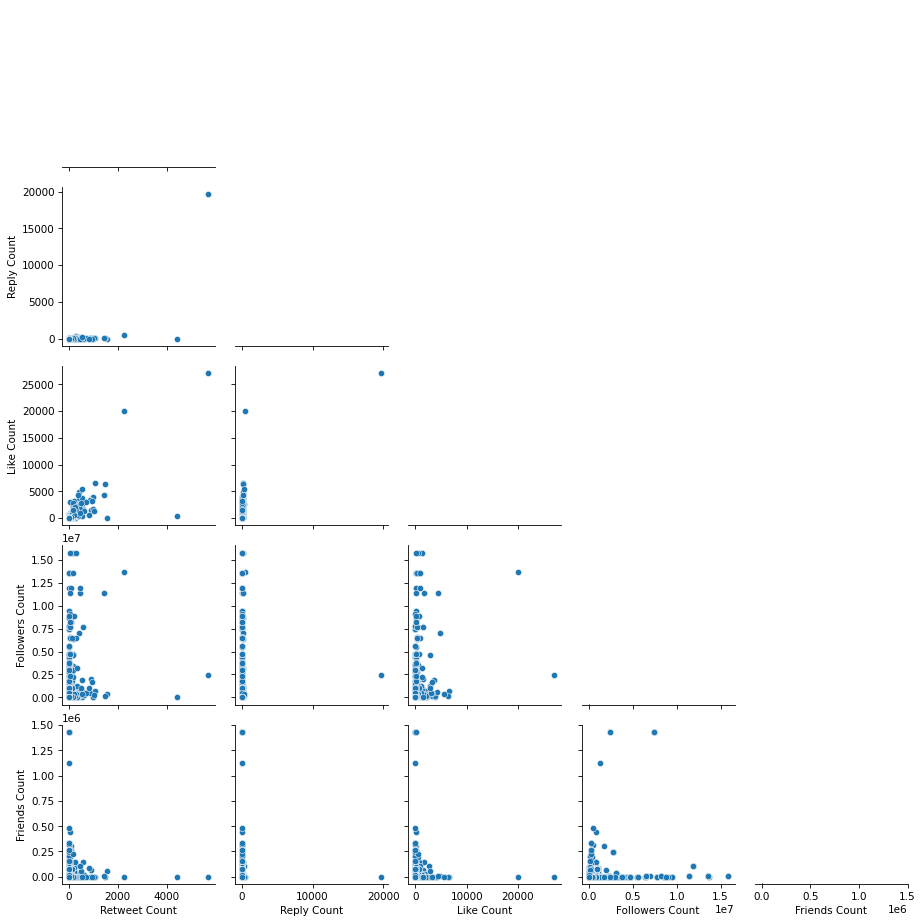

In [789]:
sns.pairplot(after_superbowl_df.filter(regex='Count$', axis = 1).reset_index(drop=True), corner=True)
#There might be some correlation between like, reply and retweet metric

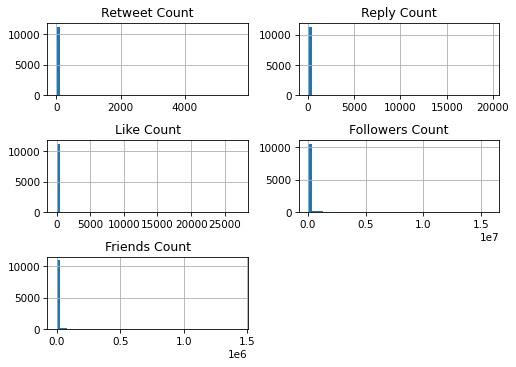

In [788]:

after_superbowl_df.filter(regex='Count$', axis = 1).reset_index(drop=True).hist(bins = 50)
plt.show()